<a href="https://colab.research.google.com/github/jbinteam/010723305/blob/main/Lecture_8_Feature_matching.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install opencv-contrib-python --upgrade # Update opencv contrib module to lastest update version

import numpy as np
import matplotlib.pyplot as plt
import cv2
from skimage import io
plt.rcParams["figure.figsize"] = (20,20)


In [2]:
def harris_corner(im_gray, blocksize=9, ksize=21,k=0.04, threshold = 70) :
    R = cv2.cornerHarris(im_gray,blocksize,ksize,k)
    #normalization
    R_normed = np.zeros(R.shape, dtype=np.float32)
    cv2.normalize(R,R_normed, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
    #thresholding
    corner = np.where(R_normed > threshold)
    R_threshold = np.zeros(R.shape)
    R_threshold[corner] = 255
    #detecting reponse contours
    contours, _hierachy = cv2.findContours(np.uint8(R_threshold), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    #list of corners location
    coords = list()

    for contour in contours :
        moment = cv2.moments(contour)
        if moment['m00'] > 0 :
            cX = int(moment['m10'] / moment['m00'])
            cY = int(moment['m01'] / moment['m00'])
            coords.append((cX,cY))
    
    return coords

In [3]:
def corner_plot(im, coords) :
    plt.imshow(im)
    plt.plot([p[0] for p in coords], [p[1] for p in coords], 'r+')

In [4]:
def patch_descriptors(im_gray, coords, patch_size = 5) :
    """ For each point returning pixel values around the point
        by neighborhood of (patch_size + 1)^2"""
    vector_length = (patch_size*2+1)**2
    desc = list()
    for coord in coords :
        patch = im_gray[coord[0]-patch_size: coord[0]+patch_size+1,             #X coordinate
                        coord[1]-patch_size: coord[1]+patch_size+1].flatten()   #Y coordinate
        if patch.shape[0] == vector_length : # prevent edge region
            desc.append(patch)
    return desc

<h1 style="text-align: center">Normalized Cross Correlation(NCC)</h1>

$$ ncc(I,J) = \frac{1}{n-1} \sum_{x} \left[  \frac{\left( I(x) - \mu_I  \right)}{\sigma_I} \cdot \frac{\left( J(x) - \mu_J  \right)}{\sigma_J} \right] $$

<h2 style="text-align: center">For the code inside the below block: </h2>

$$ d_1 = \frac{\left( I(x) - \mu_I  \right)}{\sigma_I} $$

$$ d_2 = \frac{\left( J(x) - \mu_J  \right)}{\sigma_J} $$

In [5]:
def ncc_matching(desc1, desc2, threshold = 0.5) :
    """ Normalized cross correlation descriptor matching"""
    
    # read descriptor length
    n = len(desc1[0])
    # pair-wise distance
    d = -np.ones((len(desc1), len(desc2)))
    for i in range(len(desc1)): # Brute force matching
        for j in range(len(desc2)):
            d1 = (desc1[i] - np.mean(desc1[i])) / np.std(desc1[i]) # Normalized data
            d2 = (desc2[j] - np.mean(desc2[j])) / np.std(desc2[j]) # Normalized data
            ncc_value = np.sum(d1 * d2) / (n-1)

            if ncc_value > threshold :
                d[i,j] = ncc_value
    
    ndx = np.argsort(-d)
    matchscores = ndx[:,0]

    return matchscores

In [6]:
def match_twosided(desc1, desc2, threshold = 0.5) :
    """Two sided symmetric version of match"""
    matches_12 = ncc_matching(desc1, desc2, threshold)
    matches_21 = ncc_matching(desc2, desc1, threshold)

    ndx_12 = np.where(matches_12 >= 0)[0]

    # remove matches that are not symmetric
    for n in ndx_12 :
        if matches_21[matches_12[n]] != n :
            matches_12[n] = -1
    return matches_12

In [7]:
def plot_matches(im1, im2, locs1, locs2, matchscores, show_below=True) :
    
    concat_im = cv2.hconcat([im1, im2])
    if show_below :
        concat_im = cv2.vconcat([concat_im,concat_im])
    plt.figure(figsize=(10,10))
    plt.imshow(concat_im)

    row = im1.shape[0]
    col = im1.shape[1]
    plt.plot([p[0] for p in locs1], [p[1]+row for p in locs1], 'r+') # Features plot
    plt.plot([p[0]+col for p in locs2], [p[1]+row for p in locs2], 'b+')

    for i, m in enumerate(matchscores) :
        if m > 0 :
            plt.plot([locs1[i][0], locs2[m][0]+col], [locs1[i][1], locs2[m][1]],'c') # random color c=np.random.rand(3,)

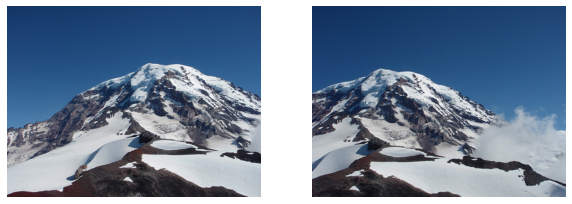

In [8]:
im_left_url = "https://github.com/jbinteam/010723305/blob/main/images/left-mountain.png?raw=true"
im_left = io.imread(im_left_url)
im_left_gray = cv2.cvtColor(im_left, cv2.COLOR_BGR2GRAY)
im_left_gray = np.float32(im_left_gray)

im_right_url = "https://github.com/jbinteam/010723305/blob/main/images/right-moutain.png?raw=true"
im_right = io.imread(im_right_url)
im_right_gray = cv2.cvtColor(im_right, cv2.COLOR_BGR2GRAY)
im_right_gray = np.float32(im_right_gray)

fig,axes = plt.subplots(1,2, figsize =(10,10))
for ax in axes :
    ax.axis('off')
axes[0].imshow(im_left)
axes[1].imshow(im_right)

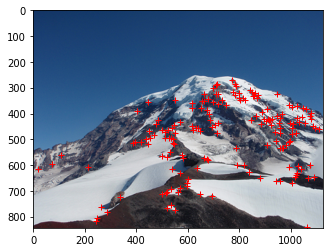

In [9]:
left_corner = harris_corner(im_left_gray)
corner_plot(im_left,left_corner)

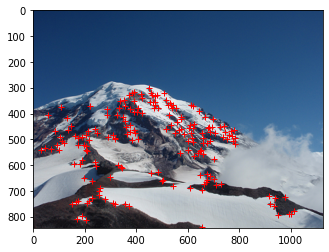

In [10]:
right_corner = harris_corner(im_right_gray)
corner_plot(im_right, right_corner)

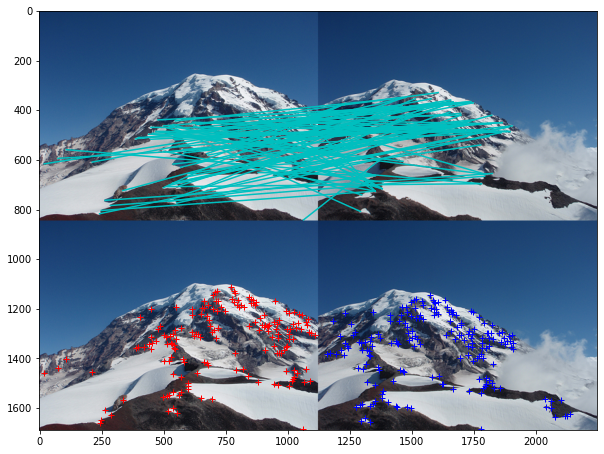

In [11]:
left_desc = patch_descriptors(im_left_gray,left_corner)
right_desc = patch_descriptors(im_right_gray, right_corner)
matches = ncc_matching(left_desc, right_desc)
# matches = match_twosided(left_desc, right_desc, 0.2)
plot_matches(im_left,im_right,left_corner,right_corner,matches)

<h1 style="text-align : center"> OpenCV <a href = "https://docs.opencv.org/master/d7/d60/classcv_1_1SIFT.html"> SIFT</a></h1>


In [12]:
sift = cv2.SIFT_create() # This method can be used only after upgrade OpenCV contrib to version more than 4.4 

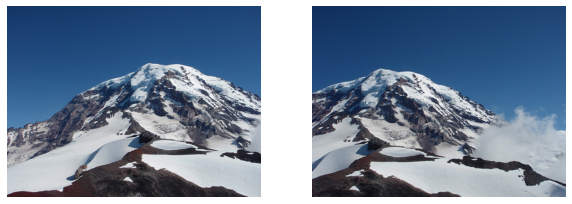

In [13]:
im_left_url = "https://github.com/jbinteam/010723305/blob/main/images/left-mountain.png?raw=true"
im_left = io.imread(im_left_url)
im_left_gray = cv2.cvtColor(im_left, cv2.COLOR_BGR2GRAY)

im_right_url = "https://github.com/jbinteam/010723305/blob/main/images/right-moutain.png?raw=true"
im_right = io.imread(im_right_url)
im_right_gray = cv2.cvtColor(im_right, cv2.COLOR_BGR2GRAY)

fig,axes = plt.subplots(1,2, figsize =(10,10))
for ax in axes :
    ax.axis('off')
axes[0].imshow(im_left)
axes[1].imshow(im_right)

<h2 style="text-align: center">SIFT feature detector & descriptor <a href="https://docs.opencv.org/4.5.3/d0/d13/classcv_1_1Feature2D.html#a8be0d1c20b08eb867184b8d74c15a677"> detectAndCompute</h2>

In [14]:
left_keypoints, left_desc = sift.detectAndCompute(im_left_gray,None)
right_keypoints, right_desc = sift.detectAndCompute(im_right_gray,None)

<h2 style="text-align: center">OpenCV keypoint(feature and descriptor) draw <a href="https://docs.opencv.org/4.5.3/d4/d5d/group__features2d__draw.html#ga5d2bafe8c1c45289bc3403a40fb88920"> drawKeypoints()</h2>

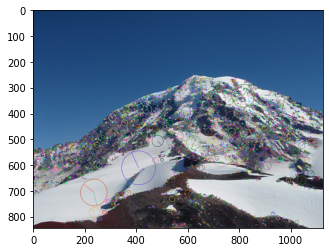

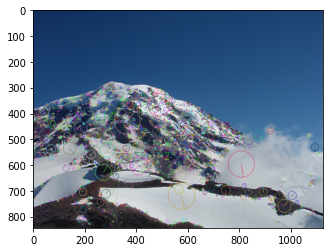

In [15]:
left_disp_keypoints = cv2.drawKeypoints(im_left, left_keypoints,None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
right_disp_keypoints = cv2.drawKeypoints(im_right, right_keypoints,None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

plt.figure()
plt.imshow(left_disp_keypoints)
plt.figure()
plt.imshow(right_disp_keypoints)

<h2 style="text-align : center"> Brute force matcher 
<a href = "https://docs.opencv.org/4.5.3/d3/da1/classcv_1_1BFMatcher.html"> BFMatcher</a>
 with 
<a href = "https://docs.opencv.org/4.5.3/db/d39/classcv_1_1DescriptorMatcher.html#a378f35c9b1a5dfa4022839a45cdf0e89"> knnMatch </a> 
</h2> 

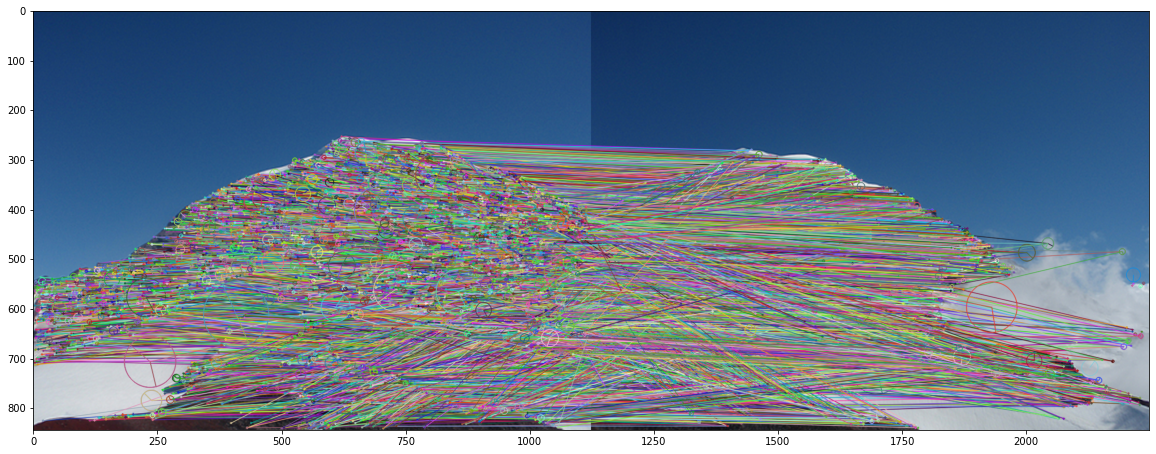

In [16]:
bf = cv2.BFMatcher()
matches = bf.knnMatch(left_desc, right_desc, k=2)
matched_img = cv2.drawMatchesKnn(im_left, left_keypoints, im_right, right_keypoints, matches, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.figure(figsize=(20,20))
plt.imshow(matched_img)

# Brute force matcher K-nearest neighbor with ratio test (David G. Lowe)

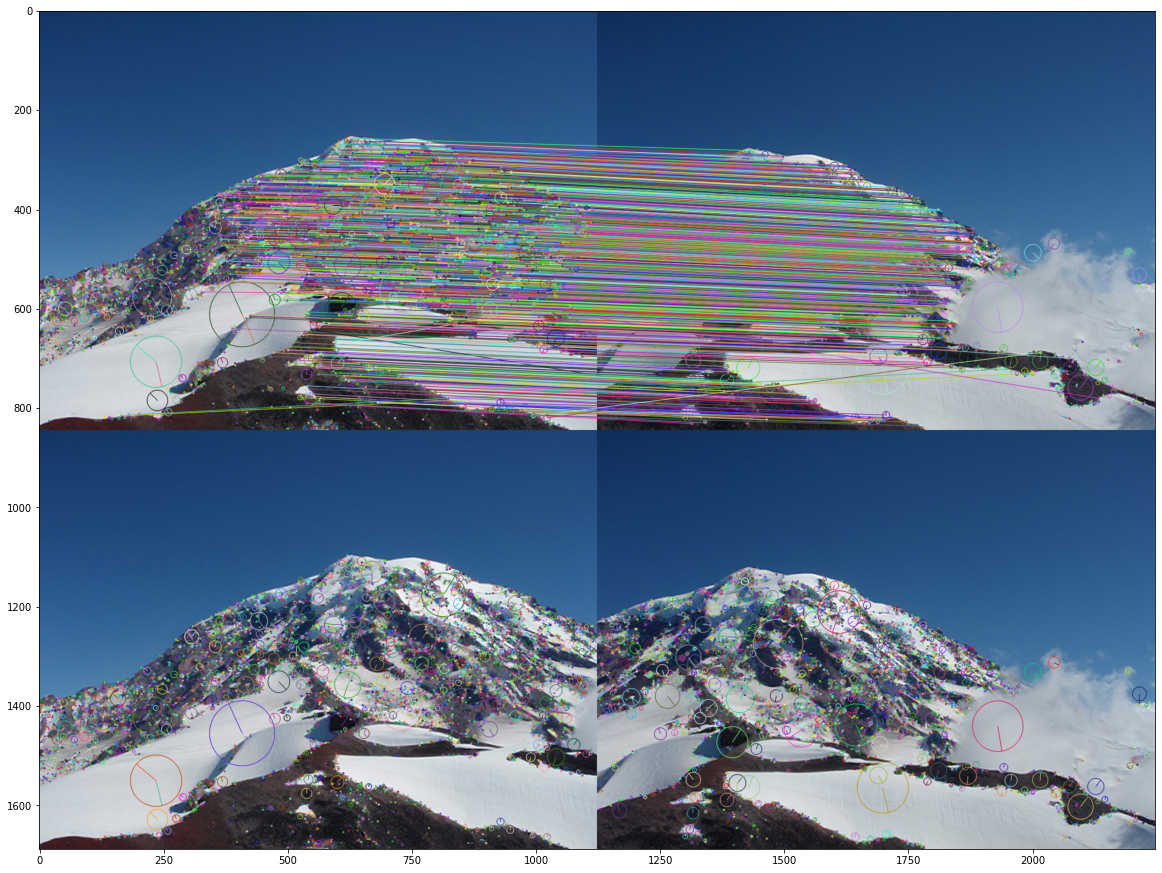

In [17]:
good_matched = list()
good_matched_list = list()

for m, n in matches :
    if m.distance < 0.7*n.distance : # distance ratio test
        good_matched.append(m)
        good_matched_list.append([m])

matched_img = cv2.drawMatchesKnn(im_left, left_keypoints, im_right, right_keypoints, good_matched_list, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
concat_img = cv2.hconcat([left_disp_keypoints, right_disp_keypoints])
concat_img = cv2.vconcat([matched_img,concat_img])
plt.figure(figsize=(20,20))
plt.imshow(concat_img)